<h1 style="font-size: 300%">Titanic survival prediction</h1>
BSHT Michielsen MSc

This notebook aims at predicting the survivability of people who were on the titanic during its disasterous sinking by applying decision trees. The main advantage of decision trees is that humans can easily understand and reproduce the sequence of decisions taken by the model to predict the target, which makes it one of the most transparent machine learning algorithms available.

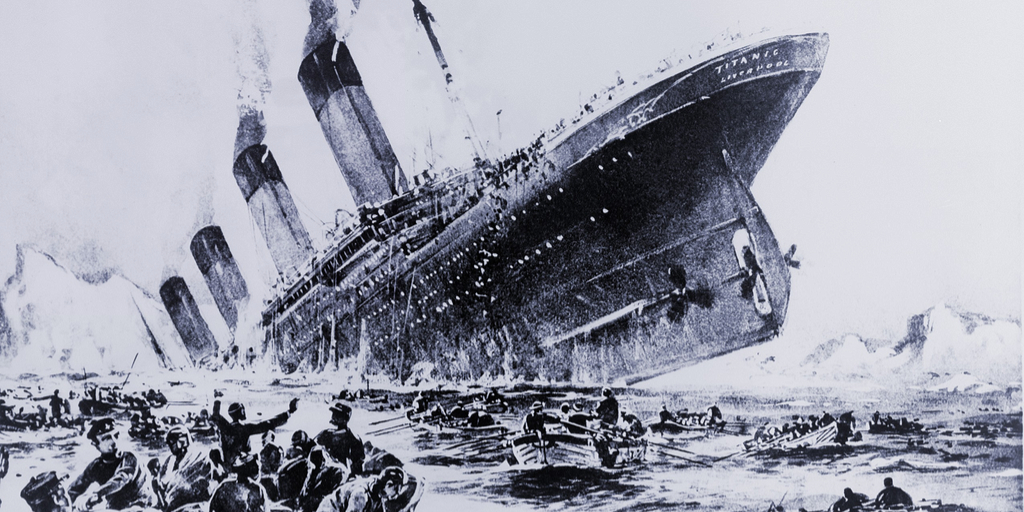


In [1]:
import sklearn
import pandas
import seaborn

print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("pandas version:", pandas.__version__)            # 1.5.1
print("seaborn version:", seaborn.__version__)          # 0.12.1

scikit-learn version: 1.7.1
pandas version: 2.3.2
seaborn version: 0.13.2


# 📦 Data provisioning

After loading the data from the csv file, it is immediately apparent that the dataset contains a large number of missing values. This notebook is an example on training a decision tree, and not on resolving data quality issues. Nevertheless a little bit of fixing is needed to make it work. Thus, the rather destructive approach of simply removing the features `pnumber`, `name`, `home.dest` and `ticket` is taken, as well as simply filling the missing values of `age` by its mean. Surely there are perhaps better ways to handle the missing data in `age` but they are outside the scope of this example.

In [2]:
df = pandas.read_csv("Titanic.csv")
df.sample(5)

,pnumber,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,sex
267,268,1st,0,"Uruchurtu, Mr Manuel E.",NaN,Cherbourg,"Mexico City, Mexico",NaN,NaN,NaN,male
87,88,1st,1,"Douglas, Mrs Frederick Charles (Suzette Baxter)",27.0,Cherbourg,"Montreal, PQ",NaN,NaN,6,female
222,223,1st,1,"Ryerson, Miss Susan (Suzette) Parker",21.0,Cherbourg,"Haverford, PA / Cooperstown, NY",NaN,17608 L262 7s 6d,4,female
324,325,2nd,0,"Andrew, Mr Edgar Samuel",18.0,Southampton,"Buenos Aires, Argentina / New Jersey, NJ",NaN,NaN,NaN,male
183,184,1st,1,"Mock, Mr Philip E.",NaN,Cherbourg,"New York, NY",NaN,NaN,11,male


In [3]:
df = df.drop(["pnumber", "name", "home.dest", "ticket"], axis=1)
df["age"] =  df["age"].fillna(df["age"].mean())


## 📃 Sample the data

A random sample of 5 observations from the data after the data provisioning.

In [4]:
df.sample(5)

,pclass,survived,age,embarked,room,boat,sex
1245,3rd,0,31.194181,NaN,NaN,NaN,male
56,1st,1,47.000000,Southampton,NaN,NaN,female
998,3rd,1,31.194181,NaN,NaN,NaN,female
144,1st,1,35.000000,Southampton,NaN,NaN,female
510,2nd,0,32.000000,Cherbourg,NaN,-43,male


# Preprocessing

## 🆔 Encoding


The features `pclass` and `sex` are currently categorical, but can fairly easily be mapped to integers because `sex` is binary and therefore can be encoded using `0` and `1`. Whereas `class` is ordinal, first class is better than second class and third class, so the integers `1`, `2` and `3` make sense.

In [5]:
df["pclass"] = df["pclass"].map({"1st":1, "2nd":2, "3rd":3}).astype(int)
df["sex"] = df["sex"].map({"male":0, "female":1}).astype(int)
df.sample(5)

,pclass,survived,age,embarked,room,boat,sex
273,1,1,55.000000,Cherbourg,NaN,8,1
1201,3,1,31.194181,NaN,NaN,NaN,1
1265,3,0,31.194181,NaN,NaN,NaN,0
845,3,0,31.194181,NaN,NaN,NaN,0
401,2,0,21.000000,Southampton,NaN,NaN,0


The feature `embarked` is categorical too, but it is a little harder to turn into an integer because the values are not binary and neither ordinal (none of the values is better than another in any sense). Therefore, a different approach is needed. Given that only one value is ever true (a passenger could not have embarked both of two different places) the approach of [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding will suffice here. The pandas function named `get_dummies` can be used for this. The result is that the dataset now has three new features with names equal to the values of the `embarked` column and in just one of them there is a `1` which indicates the place in which the passenger embarked. Note that the fact that sometimes `embarked` is missing is ignored, and this approach will simply put `0` in every one of the three new features, which is technically wrong.

In [6]:
df = pandas.concat([df, pandas.get_dummies(df["embarked"])], axis=1)
df = df.drop("embarked", axis=1)
df.sample(5)

,pclass,survived,age,room,boat,sex,Cherbourg,Queenstown,Southampton
974,3,0,31.194181,NaN,NaN,0,False,False,False
134,1,0,55.000000,NaN,-307,0,False,False,True
1105,3,0,31.194181,NaN,NaN,0,False,False,False
352,2,1,36.000000,E-?,9,1,False,False,True
1017,3,0,31.194181,NaN,NaN,0,False,False,False


The features `room` and `boat` are dropped instead of being encoded, because in the case of `room` it is hard to turn it into a numeric value that is actually useful for the machine to train on. The room number itself is probably useless, however, the distance from the room to a lifeboat might actually have been an interesting feature. However, without a map of the titanic, this distance cannot be inferred from the room number. The case of `boat` is different because `survived` and `boat` are not independent. In order to survive you need to have reached a lifeboat, so any value in the `boat` feature is highly likely to result in having survived the disaster. However, a conclusion like "If you were in a life boat, you are likely to have survived." is rather trivial. Therefore `boat` becomes a feature that is not going to be selected anyway. Note that for legibility reasons the target is moved to the end of the data set.

In [7]:
df = df[["pclass", "sex", "age", "Cherbourg", "Queenstown", "Southampton", "survived"]]
df.sample(5)

,pclass,sex,age,Cherbourg,Queenstown,Southampton,survived
376,2,1,8.000000,False,False,True,1
260,1,1,31.194181,False,False,True,1
1073,3,1,31.194181,False,False,False,0
825,3,1,43.000000,False,False,True,0
165,1,0,31.194181,False,False,False,0



## 💡 Feature selection

A heatmap will be used to select a suitable set of features to predict the `survived` target upon.

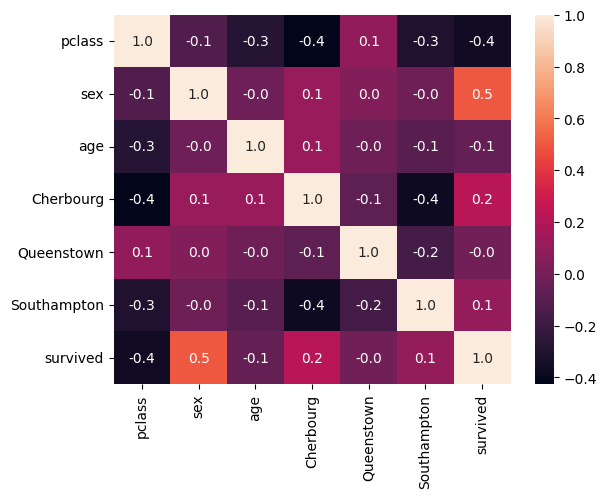

In [8]:
correlations = df.corr()
plot = seaborn.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

Apparently the class of the ticket and the sex of the passenger are most indicative for survivability. Since we choose the value `1` for female and `0` for male, the correlation coefficient of positive `0.5` indicates that when the value for `sex` goes up, survivability also goes up, so females have a higher chance to survive than males. Similarly when the value for `pclass` goes up (and therefore the class goes down, because 1st class is higher than 3rd class) survivability goes down, in other words, 1st class passenger were more likely to survive than other classes. Additionally, passengers that embarked in Cherbourg seem to have a little higher survivability too, which is not easily explained. Surprisingly however, the age does have little influence, which is unexpected because the consensus in case of disaster of that time was that women and children are to be saved first. This is probably why `sex` does correlate well with `survived`, as mentioned before, but does not explain why `age` does not correlate well.

For now, no investigation into age is undertaken but merely the features `pclass`, `sex` and `Cherbourg` are selected to continue. 

In [9]:
features = ["pclass", "sex", "Cherbourg"]
target = "survived"

X = df[features]
y = df[target]

## 🪓 Splitting into train/test

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 1313 observations, of which 1050 are now in the train set, and 263 in the test set.


# Modelling

In [11]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.7908745247148289


It is possible to ask the decision tree which features it considers import in deciding the outcome and which features it considers less import. The values are fractions which add up to 100%.

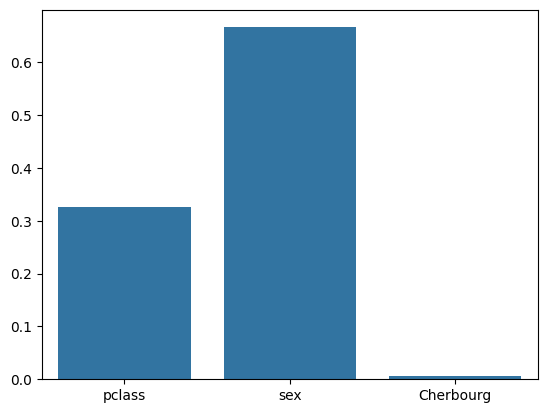

In [12]:
plot = seaborn.barplot(y=model.feature_importances_, x=features)

As expected the feature `sex` has the greatest influence (~65%) on the decision that the tree will take, followed by the feature `pclass` (~33%). The feature `Cherbourg` has very little influence and it is perhaps better eliminated as to reduce the complexity of the model.

The biggest advantage of using a decision tree is that the tree itself can be drawn as to give insight in what actually happens inside the tree. For humans this is an understandable process that greatly improves the transparency of the modelling step.

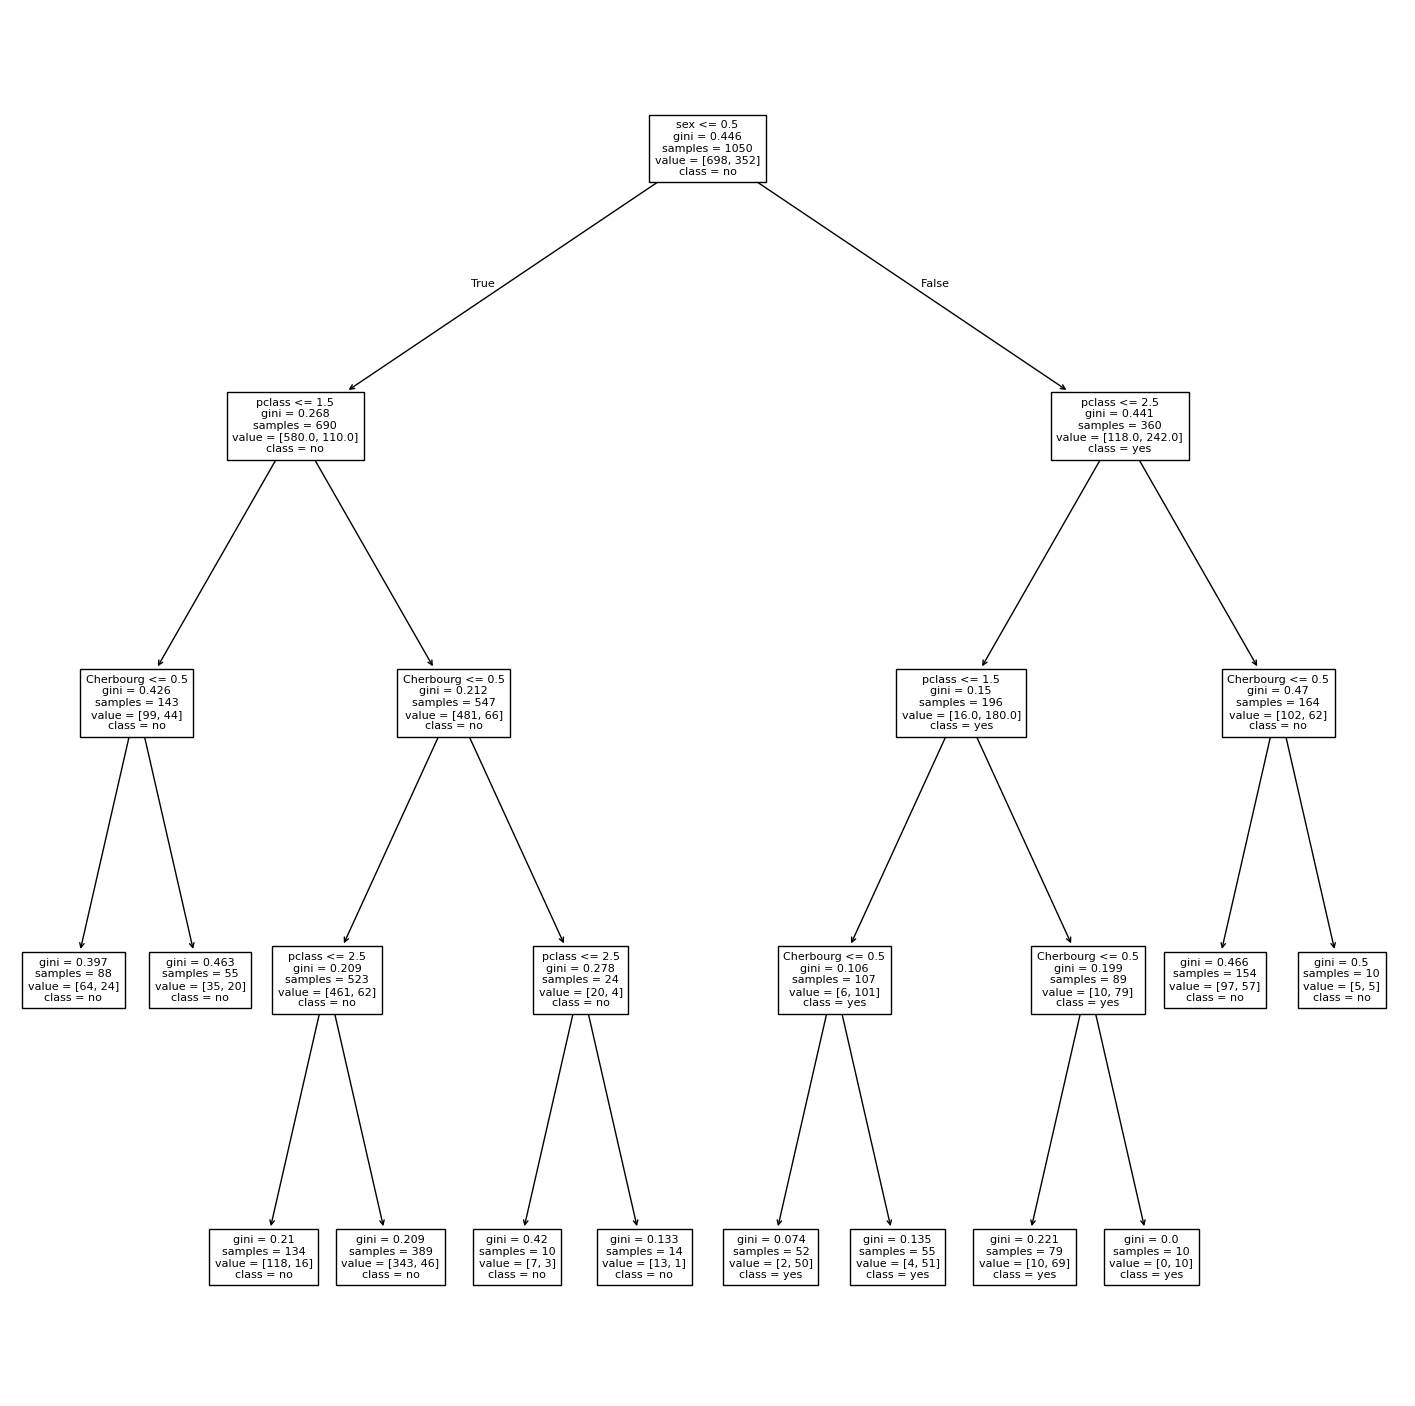

In [13]:
target_names = ["no", "yes"]
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
from sklearn.tree import plot_tree
plot_tree(model, fontsize=8, feature_names=features, class_names=target_names)
plt.show()

# Evaluation
This notebook produces slightly different results every time it is ran due to the random train/test split. However, calculating the evaluation metrics for the train set as well as the test set gives us insight in whether the model is overfitted or not. If the trainset results are a lot better than the testset results, it means that the model is trained a little too well on the train set and therefore generalizes badly in the real world.

In [14]:
from sklearn.metrics import classification_report

print("Train set:")
predictions = model.predict(X_train)
report = classification_report(y_train, predictions, target_names=target_names)
print(report)

print("Test set:")
predictions = model.predict(X_test)
report = classification_report(y_test, predictions, target_names=target_names)
print(report)

Train set:
              precision    recall  f1-score   support

          no       0.80      0.98      0.88       698
         yes       0.92      0.51      0.66       352

    accuracy                           0.82      1050
   macro avg       0.86      0.74      0.77      1050
weighted avg       0.84      0.82      0.80      1050

Test set:
              precision    recall  f1-score   support

          no       0.77      0.96      0.85       166
         yes       0.89      0.49      0.64        97

    accuracy                           0.79       263
   macro avg       0.83      0.73      0.74       263
weighted avg       0.81      0.79      0.77       263



Running the notebook a few times one will notice that sometimes the results for the testset are a little different from the trainset, but not greatly so. In conclusion, the model is not overfitted and will generalize well in the real world.

# Inference

Now let us try a few fictionally persons, and see whether they would have survived the Titanic Disaster or not.

First class female, not from Cherbourg.

In [15]:
data = {"pclass": 1, "sex": 1, "Cherbourg": 0}

X_inference = pandas.DataFrame([data])
prediction = model.predict_proba(X_inference)
result = pandas.DataFrame()
result["Outcome"] = target_names
result["Probability"] = prediction[0]
result

,Outcome,Probability
0,no,0.038462
1,yes,0.961538


Second class male, from Cherbourg.

In [16]:
data = {"pclass": 2, "sex": 0, "Cherbourg": 1}

X_inference = pandas.DataFrame([data])
prediction = model.predict_proba(X_inference)
result = pandas.DataFrame()
result["Outcome"] = target_names
result["Probability"] = prediction[0]
result

,Outcome,Probability
0,no,0.7
1,yes,0.3


First class male, from Cherbourg.

In [17]:
data = {"pclass": 1, "sex": 0, "Cherbourg": 1}

X_inference = pandas.DataFrame([data])
prediction = model.predict_proba(X_inference)
result = pandas.DataFrame()
result["Outcome"] = target_names
result["Probability"] = prediction[0]
result

,Outcome,Probability
0,no,0.636364
1,yes,0.363636


Exercise 1: What happens when I remove the 'Cherbourg' feature?

In [18]:
print("Testing my model without the Cherbourg feature")
print("=" * 50)

# I want to see if removing Cherbourg changes my accuracy
# My original model used: ['pclass', 'sex', 'Cherbourg']
# Now I'll try just: ['pclass', 'sex']

# Set up my new features (without Cherbourg)
my_features = ['pclass', 'sex']
target = 'survived'

# Get my data ready
X_new = df[my_features]  # My input data
y = df[target]          # What I'm trying to predict

# Split my data like before
from sklearn.model_selection import train_test_split
X_train_new, X_test_new, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42
)

# Train my new model
from sklearn.tree import DecisionTreeClassifier
my_new_model = DecisionTreeClassifier(random_state=42)
my_new_model.fit(X_train_new, y_train)

# Check how both models perform
original_accuracy = model.score(X_test, y_test)        # My first model
new_accuracy = my_new_model.score(X_test_new, y_test)  # My new model

print(f"My original model accuracy: {original_accuracy:.3f}")
print(f"My new model accuracy:      {new_accuracy:.3f}")
print(f"Difference:                 {abs(original_accuracy - new_accuracy):.3f}")

if abs(original_accuracy - new_accuracy) < 0.01:
    print("The accuracy barely changed!")
else:
    print("There's a noticeable difference in accuracy.")

# Look at what features matter most in each model
print("\nFeature importance comparison:")
print("In my original model:")
for feature, importance in zip(['pclass', 'sex', 'Cherbourg'], model.feature_importances_):
    print(f"  {feature}: {importance:.3f}")

print("In my new model:")
for feature, importance in zip(my_features, my_new_model.feature_importances_):
    print(f"  {feature}: {importance:.3f}")

Testing my model without the Cherbourg feature
My original model accuracy: 0.608
My new model accuracy:      0.817
Difference:                 0.209
There's a noticeable difference in accuracy.

Feature importance comparison:
In my original model:
  pclass: 0.327
  sex: 0.666
  Cherbourg: 0.007
In my new model:
  pclass: 0.333
  sex: 0.667


Why I'm doing this exercise: Looking at my original model results, I noticed that the 'Cherbourg' feature had really low importance compared to 'sex' and 'pclass'. I want to test if removing this weak feature will actually hurt my model's accuracy or if it'll stay about the same.

What I think will happen: Since Cherbourg wasn't contributing much to begin with, I expect the accuracy to stay pretty much the same when I remove it.

My reasoning: If a feature isn't really helping with predictions, then getting rid of it should make my model simpler without making it worse. This is what my professor called "feature selection" - only keeping the features that actually matter.

Exercise 2: Trying Decision Trees on the Iris Dataset

Let me try classifying Iris flowers!
What's in this Iris dataset?
Number of flowers: 150
Number of features: 4
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

First few flowers:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   flower_type  
0            0  
1            0  
2            0  
3            0  
4            0  

My Iris model accuracy: 1.000

Which flower measurements matter most:
  sepal length (cm): 0.000
  sepal width (cm): 0.000
  petal length (cm): 0.927
  petal width (cm): 0.073


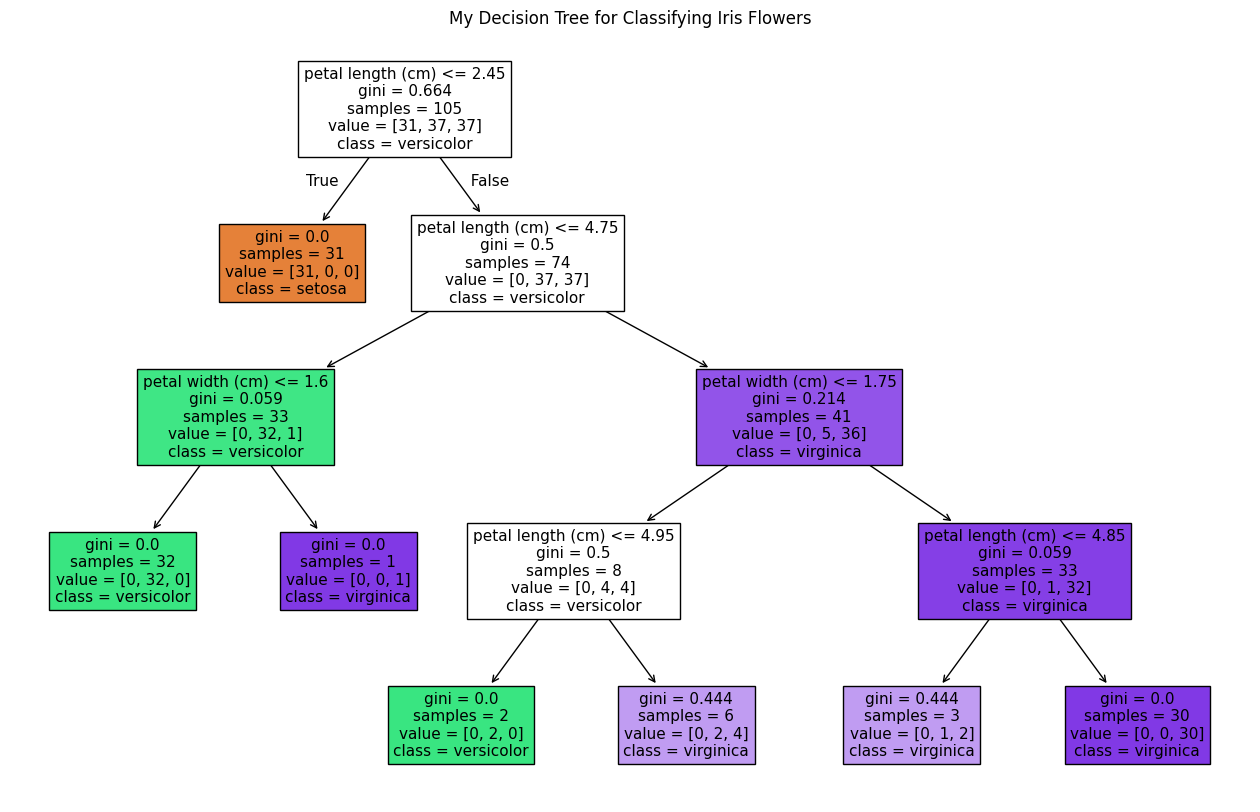


Looking at my tree:
- Can I follow the decision path from top to bottom?
- Do the splits make sense for distinguishing flowers?
- Is it simpler or more complex than I expected?


In [19]:
print("Let me try classifying Iris flowers!")
print("=" * 40)

# Load the Iris dataset that everyone talks about
from sklearn.datasets import load_iris
iris_data = load_iris()

# Make it into a DataFrame so I can work with it easier
import pandas as pd
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df['flower_type'] = iris_data.target

print("What's in this Iris dataset?")
print(f"Number of flowers: {iris_df.shape[0]}")
print(f"Number of features: {iris_df.shape[1] - 1}")
print(f"Features: {list(iris_data.feature_names)}")
print("\nFirst few flowers:")
print(iris_df.head())

# Set up my data for machine learning
X_iris = iris_df[iris_data.feature_names]  # The measurements
y_iris = iris_df['flower_type']            # Which type of flower (0, 1, or 2)

# Split into training and testing data
from sklearn.model_selection import train_test_split
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42
)

# Train my decision tree
from sklearn.tree import DecisionTreeClassifier
my_iris_model = DecisionTreeClassifier(max_depth=4, random_state=42)
my_iris_model.fit(X_train_iris, y_train_iris)

# See how well it worked
iris_accuracy = my_iris_model.score(X_test_iris, y_test_iris)
print(f"\nMy Iris model accuracy: {iris_accuracy:.3f}")

# Check which measurements the tree thinks are most important
print("\nWhich flower measurements matter most:")
for feature, importance in zip(iris_data.feature_names, my_iris_model.feature_importances_):
    print(f"  {feature}: {importance:.3f}")

# Draw the decision tree so I can see how it makes decisions
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 10))
plot_tree(my_iris_model, 
          feature_names=iris_data.feature_names,
          class_names=['setosa', 'versicolor', 'virginica'],
          filled=True,
          fontsize=11)
plt.title("My Decision Tree for Classifying Iris Flowers")
plt.show()

print("\nLooking at my tree:")
print("- Can I follow the decision path from top to bottom?")  
print("- Do the splits make sense for distinguishing flowers?")
print("- Is it simpler or more complex than I expected?")

Why I chose the Iris dataset: I picked Iris because it seems like a good dataset to learn with. The features are easy to understand (just flower measurements like petal length), there are only 3 types of flowers to classify, and I've heard that decision trees work really well on this kind of data.

What I expect to see: I think the tree will be pretty accurate and not too complicated to read. Based on what I know about flowers, I'm guessing the petal measurements will be more important than the sepal ones for telling the species apart.

What I want to analyze: When I look at the tree visualization, I'm going to check if I can actually follow the decision-making process from start to finish. Do the splits make sense from what I know about how flowers are different? Is the tree more or less complex than I thought it would be?

Exercise 3: Testing Different Tree Settings (Hyperparameters)

Let me try different settings for my decision tree
Training my three different models...

Default Tree:
  Training accuracy: 0.667
  Test accuracy:     0.643
  Tree depth:        4
  Number of leaves:  12
  Overfitting?       No (0.024 difference)

Shallow Tree:
  Training accuracy: 0.663
  Test accuracy:     0.639
  Tree depth:        3
  Number of leaves:  8
  Overfitting?       No (0.024 difference)

Careful Tree:
  Training accuracy: 0.667
  Test accuracy:     0.643
  Tree depth:        4
  Number of leaves:  12
  Overfitting?       No (0.024 difference)



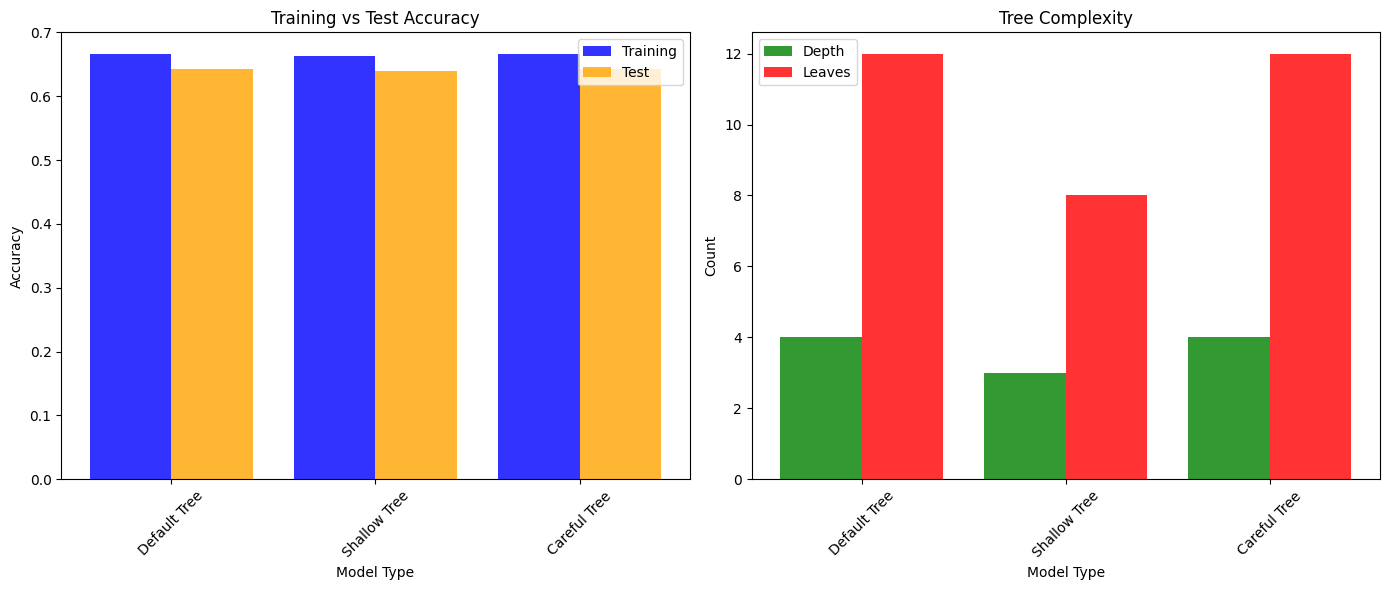

Questions I'm thinking about:
1. Which model has the biggest gap between training and test accuracy?
2. What does a big gap tell me about overfitting?
3. If I had to pick one model for real use, which would I choose?
4. What's the main point of adjusting these parameters anyway?


In [ ]:
print("Let me try different settings for my decision tree")
print("=" * 55)

# I want to test how different "tree rules" affect my model
# I'll try 3 different approaches on my Titanic data

# Approach 1: Let the tree grow however it wants (default)
model_default = DecisionTreeClassifier(random_state=42)

# Approach 2: Keep the tree shallow (max 3 levels)
model_shallow = DecisionTreeClassifier(max_depth=3, random_state=42)

# Approach 3: Be more careful about splits (conservative)
model_careful = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=10,    
    min_samples_leaf=5,     
    random_state=42
)

# Train all three models and see what happens
my_models = [model_default, model_shallow, model_careful]
model_names = ["Default Tree", "Shallow Tree", "Careful Tree"]

print("Training my three different models...")
print()

my_results = []
for i, (model, name) in enumerate(zip(my_models, model_names)):
    # Train each model
    model.fit(X_train, y_train)
    
    # Test how well it remembers the training data
    train_score = model.score(X_train, y_train)
    
    # Test how well it works on completely new data
    test_score = model.score(X_test, y_test)
    
    # Get some info about the tree size
    tree_depth = model.get_depth()
    num_leaves = model.get_n_leaves()
    
    print(f"{name}:")
    print(f"  Training accuracy: {train_score:.3f}")
    print(f"  Test accuracy:     {test_score:.3f}")  
    print(f"  Tree depth:        {tree_depth}")
    print(f"  Number of leaves:  {num_leaves}")
    
    # Check if it's overfitting (big difference between train and test)
    overfitting = train_score - test_score
    if overfitting > 0.05:
        print(f"  Overfitting?       Yes ({overfitting:.3f} difference)")
    else:
        print(f"  Overfitting?       No ({overfitting:.3f} difference)")
    print()

# Make some simple charts to visualize the differences
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1: Compare training vs test accuracy
train_scores = [model.score(X_train, y_train) for model in my_models]
test_scores = [model.score(X_test, y_test) for model in my_models]

x_pos = range(len(model_names))
ax1.bar([i-0.2 for i in x_pos], train_scores, 0.4, label='Training', alpha=0.8, color='blue')
ax1.bar([i+0.2 for i in x_pos], test_scores, 0.4, label='Test', alpha=0.8, color='orange')
ax1.set_xlabel('Model Type')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training vs Test Accuracy')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend()

# Chart 2: Compare tree complexity
depths = [model.get_depth() for model in my_models]
leaves = [model.get_n_leaves() for model in my_models]

ax2.bar([i-0.2 for i in x_pos], depths, 0.4, label='Depth', alpha=0.8, color='green')
ax2.bar([i+0.2 for i in x_pos], leaves, 0.4, label='Leaves', alpha=0.8, color='red')
ax2.set_xlabel('Model Type')
ax2.set_ylabel('Count')
ax2.set_title('Tree Complexity')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(model_names, rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

print("Questions I'm thinking about:")
print("1. Which model has the biggest gap between training and test accuracy?")
print("2. What does a big gap tell me about overfitting?")
print("3. If I had to pick one model for real use, which would I choose?")
print("4. What's the main point of adjusting these parameters anyway?")

Why hyperparameter tuning matters to me: This is helping me understand overfitting, which is when a model gets really good at memorizing the training data but fails on new data. It's like cramming for a test by memorizing specific answers instead of actually learning the concepts.
What I'm trying to achieve: The hyperparameters I'm testing should help prevent overfitting:

max_depth stops my tree from getting too complicated
min_samples_split makes sure I have enough data before making a split (so I'm more confident)
min_samples_leaf ensures each final prediction is based on enough examples

My prediction: I think the default model will probably get the highest accuracy on training data, but it might not do as well when I test it on completely new data because it's overfitting.